# IMPORTS

In [1]:
import ohsome
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

import datetime
import shapely

import json

from pathlib import Path
from time import sleep

# MISC.

In [2]:
tex_fonts = {
        "text.usetex": True,
        "font.family": "serif",
        "axes.titlesize": 10, 
        "axes.labelsize": 10,
        "font.size": 10,
        "legend.fontsize": 'xx-small',
        "legend.title_fontsize": 10,
        "xtick.labelsize": 8, #'xx-small',
        "ytick.labelsize": 8, #'xx-small',
        "ps.usedistiller": "xpdf"
        }
plt.rcParams.update(tex_fonts)
plt.rcParams['text.latex.preamble'] = r'\usepackage{amsmath,amssymb,underscore}'

In [3]:
cm=1/2.54

In [4]:
path_geo = Path('/home/lemasle/GEO/test_geospatial')
path_geo = Path('/home/lemasle/GEO/test_geospatial/plots')

# CLIENT

In [5]:
client = ohsome.OhsomeClient()

# FILTERS

In [6]:
# Certainly room for improvement in the definition of these filters

In [7]:
solar = "(power=plant and plant:source=solar) or (power=generator and generator:source=solar)"
roads = "type:way and (highway in (motorway, motorway_link, trunk, trunk_link, primary, primary_link, secondary, secondary_link, tertiary, tertiary_link, unclassified, residential, living_street) or (highway=service and service=alley)))"
bike_path = "type:way and ((sidewalk:left:bicycle=yes) or (cycleway:left=shared_lane) or (cyclestreet=yes) or (cycleway:left=shared_busway) or (cycleway:right=shared_busway) or (cycleway=shared_busway) or (cycleway=opposite_lane) or (highway=bridleway and bicycle=no) or (highway=track and bicycle=designated and motor_vehicle=no) or (bicycle=use_sidepath) or (cycleway=opposite and oneway:bicycle=no) or (sidewalk:right:bicycle=yes) or (cycleway:right=shared_lane) or (cycleway:left=track) or  (cycleway:right=track) or (highway=track and bicycle=designated and motor_vehicle=no) or (highway=path and bicycle=yes) or (highway=path and (bicycle=designated or bicycle=official)) or (highway=service and (bicycle=designated or motor_vehicle=no)) or (highway=pedestrian and (bicycle=yes or bicycle=official)) or (highway=footway and (bicycle=yes or bicycle=official)) or (highway=cycleway) or (cycleway in (lane, opposite_lane, shared_busway, track, opposite_track)) or (cycleway:left in (lane, shared_busway)) or (cycleway:right in (lane, shared_busway)) or (cycleway:both=lane) or (bicycle_road=yes and (motor_vehicle=no or bicycle=designated)) or (cyclestreet=yes))"

# QUERIES

In [8]:
# Very rough description of Heidelberg as square box
bboxes_HD = [8.6581,49.3836,8.7225,49.4363]

# Time interval in which data is queried
time = "2010-03-01T13:00:00Z/2023-07-01T15:30:00Z/P1M"

# FUNCTIONS

In [9]:
# This function is a workaround to retrieve data in dataframes via json files since as_dataframe() conversion returns an error

def retrieve_df(region, time, filter, endpoint):

    if endpoint == 'count': 
        end = "elements/count"
    elif endpoint == 'length':
        end = "elements/length"
    else:
        print('Invalid endpoint')
               
    query = client.post(region, time=time, filter=filter, endpoint=end)
    query.to_json("./query.json")
    temp = json.load(open("./query.json"))
    
    df = pd.DataFrame(temp["result"])
    # convert timestamp to datetime format and keep only the date
    df['timestamp']= pd.to_datetime(df['timestamp']).dt.date
    
    return df

# BIKEPATHS

In [10]:
HD_bike_count = retrieve_df(bboxes_HD, time, bike_path, 'count')
sleep(10)
HD_bike_length = retrieve_df(bboxes_HD, time, bike_path, 'length')

In [11]:
HD_bike_count.rename(columns={'value': 'bikepath_count'}, inplace=True)
HD_bike_length.rename(columns={'value': 'bikepath_length'}, inplace=True)
HD_bike_length.head()

,timestamp,bikepath_length
0,2010-03-01,55590.53
1,2010-04-01,55424.66
2,2010-05-01,55482.25
3,2010-06-01,55804.73
4,2010-07-01,56606.16


In [12]:
HD_road_length = retrieve_df(bboxes_HD, time, 'highway=*', 'length')
HD_road_length.rename(columns={'value': 'road_length'}, inplace=True)
HD_road_length

,timestamp,road_length
0,2010-03-01,483153.53
1,2010-04-01,485253.51
2,2010-05-01,486031.80
3,2010-06-01,486732.82
4,2010-07-01,487819.14
...,...,...
156,2023-03-01,696925.87
157,2023-04-01,697184.53
158,2023-05-01,697586.71
159,2023-06-01,697863.78


In [13]:
HD = HD_bike_length.merge(HD_road_length, left_on='timestamp', right_on='timestamp')
HD['bike_road_length_ratio']= HD.bikepath_length/HD.road_length*100

In [14]:
def plot_bikepath_HD(df, path, filename, cm):

    from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset

    fig = plt.figure(figsize=(14*cm, 10*cm))
    ax_ratio = fig.add_subplot(111)

    df['timestamp']= pd.to_datetime(df['timestamp'])
    ax_ratio.plot(df.timestamp, df.bike_road_length_ratio, c='Dodgerblue', lw=2)    
    
    ax_ratio.set(
        title=r"Evolution of the ratio of bike paths vs normal roads in Heidelberg",
        xlabel=r"Time [yr]",
        ylabel=r"Ratio of bike paths vs normal roads [\%]",
        ylim=[0, 17],
        )
    #ax_ratio.get_legend().remove()    

    # axin1 = ax.inset_axes([0.8, 0.1, 0.15, 0.15]) #[x0, y0, width, height]
    # axin2 = ax.inset_axes([5, 7, 2.3, 2.3], transform=ax.transData)


    
    # insert plot showing the individual time5 evolution of bikepaths & roads
    axins = ax_ratio.inset_axes([0.45, 0.15, 0.5, 0.4]) #[x0, y0, width, height]
    #axins = inset_axes(ax_ratio, width="45%", height="30%", loc= 'lower right', bbox_to_anchor=None, borderpad=5)
    axins.plot(df['timestamp'], df['bikepath_length']/1000, c='blue', lw=1, label='bikepaths')
    axins.plot(df['timestamp'], df['road_length']/1000, c='navy', lw=1, label='roads')

    axins.set(
        title=r"Evolution of the network length",
        xlabel=r"Time [yr]",
        ylabel=r"Network length [km]",
        ylim=[0, 800],
    )
    axins.legend(loc='upper left')
    
    file = path / str(filename)
    fig.savefig(file, format='pdf')

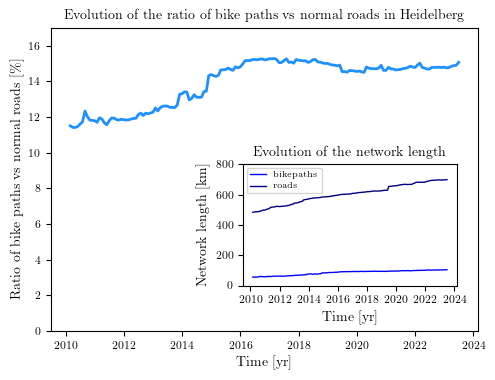

In [15]:
plot_bikepath_HD(HD, path_geo, 'Bike_path_HD.pdf', cm)

# Solar Energy

In [16]:
HD_solar_count = retrieve_df(bboxes_HD, time, solar, 'count')
HD_solar_count.rename(columns={'value': 'solar_count'}, inplace=True)
HD_solar_count.head()

,timestamp,solar_count
0,2010-03-01,0.0
1,2010-04-01,0.0
2,2010-05-01,0.0
3,2010-06-01,0.0
4,2010-07-01,0.0


In [17]:
def plot_solar_HD(df, path, filename, cm):

    fig = plt.figure(figsize=(14*cm, 10*cm))
    ax_solar = fig.add_subplot(111)

    df['timestamp']= pd.to_datetime(df['timestamp'])
    ax_solar.plot(df.timestamp, df.solar_count, c='Dodgerblue', lw=2, label = 'Reported Solar energy sources')    
    
    ax_solar.set(
        title=r"Evolution of the number of Solar energy sources in Heidelberg",
        xlabel=r"Time [yr]",
        ylabel=r"Number of objects",
        ylim=[8, 100],
        )
    ax_solar.legend(loc='upper left')  
    
    file = path / str(filename)
    fig.savefig(file, format='pdf')

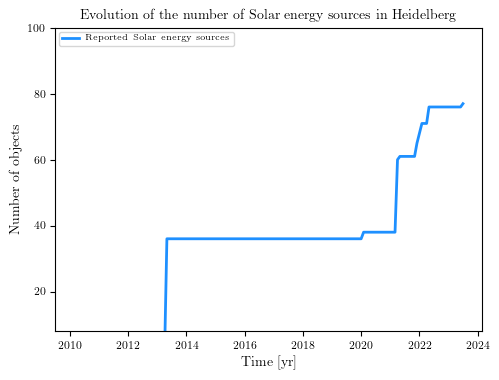

In [18]:
plot_solar_HD(HD_solar_count, path_geo, 'Solar_count_HD.pdf', cm)